# Projeto de An√°lise Preditiva de Inadimpl√™ncia

### Simula√ß√£o de ganhos em decis√£o de cr√©dito com uso de modelo preditivo

Esta simula√ß√£o tem como objetivo estimar o impacto financeiro da aplica√ß√£o de um modelo de Machine Learning na decis√£o de aprovar ou negar cr√©dito para clientes, comparando com o cen√°rio onde o banco aprova todos indiscriminadamente. 

#### Cen√°rio A: Com Modelo 

Neste cen√°rio, usamos um modelo preditivo (Random Forest) treinado com os dados dos clientes. A decis√£o de aprovar ou negar cr√©dito √© baseada na previs√£o do modelo: 

- Se o modelo prev√™ que o cliente vai pagar (classe 0) ‚Üí APROVA; 
- Se o modelo prev√™ que o cliente vai dar calote (classe 1) ‚Üí NEGA. 



 

A qualidade do modelo foi avaliada por meio da matriz de confus√£o com os seguintes valores aproximados:

VP (bons aprovados): 5.121 clientes

FP (ruins aprovados): 0 (ou calculado a partir do dataset)

FN (bons negados): estimado em 30% do lucro perdido por cliente bom negado


C√°lculo de Lucro com Modelo:

Lucro por cliente bom aprovado (VP): R$ 1.000

Preju√≠zo por cliente ruim aprovado (FP): R$ 3.000

Perda de oportunidade por cliente bom negado (FN): R$ 300

Negar cliente ruim (VN): sem ganho ou perda

Resultados:

- Lucro com modelo: R$ 5.121.000,00

- Lucro sem modelo (aprova√ß√£o irrestrita): R$ 3.814.000,00

- Ganho incremental = 5.121.000 - 3.814.000 = 1.307.000

- Melhoria percentual = (1.307.000 / 3.814.000) * 100 ‚âà 34,3%

#### Cen√°rio B: Sem Modelo 

1. Regras Manuais

A estrat√©gia baseada em regras manuais considerou os seguintes crit√©rios para aprova√ß√£o:

- Score externo (ext_score_1) acima de 550
- Renda superior a R$ 3.000
- Ocupa√ß√£o do tipo "CLT", "public" ou "servidor p√∫blico"

2. Resultados:
Taxa de aprova√ß√£o: aproximadamente 21% dos clientes

Inadimpl√™ncia entre os aprovados: 63,65%

Lucro estimado total: R$ 3.814.000 

Cen√°rio B: 

Lucro sem modelo

- Total de bons clientes = VP + FN = 8700 + 220 = 8920

- Total de maus clientes = FP + VN = 1171 + 531 = 1702

              Lucro¬†sem¬†modelo = 8920 x 1000 ‚àí 1702 x 3000

              Lucro¬†sem¬†modelo = 8.920.000 ‚àí 5.106.000 = R$ 3.814.000

Insghts:  

O uso do modelo preditivo resultaria em um ganho estimado de mais de 34% em compara√ß√£o com a aprova√ß√£o irrestrita de cr√©dito. 
A estrat√©gia baseada em Machine Learning √© altamente recomend√°vel para maximizar lucros e mitigar riscos de inadimpl√™ncia. 

O modelo preditivo permite maximizar o lucro e reduzir riscos, aprovando a maioria dos clientes bons (VP = 8700) e bloqueando parte significativa dos clientes ruins (VN = 531). Mesmo alguns maus clientes passam pelo modelo (FP = 1171), o ganho total supera significativamente a estrat√©gia de aprova√ß√£o irrestrita

Essa an√°lise evidencia que a incorpora√ß√£o de modelos preditivos no processo de decis√£o pode otimizar a pol√≠tica de cr√©dito, combinando maior retorno financeiro com controle de risco.

#### Modelo em produ√ß√£o:

In [18]:
import os
import random
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
import warnings
import category_encoders as ce

from scipy.stats import f_oneway
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from xgboost import XGBClassifier
from sklearn.compose import make_column_selector
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.calibration import calibration_curve,CalibratedClassifierCV 
from sklearn.metrics import brier_score_loss

# Sklearn - pr√©-processamento, m√©tricas e modelagem
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, 
    cross_val_score, cross_validate, KFold
)
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

# Configura√ß√µes gerais
warnings.filterwarnings('ignore')

# Reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

##### CARREGAMENTO E AN√ÅLISE INICIAL DOS DADOS

In [2]:
# Carregar dados
df = pd.read_pickle('../data/df_unique.pkl')
print(f"Shape inicial: {df.shape}")
print(f"Taxa de inadimpl√™ncia: {df['default'].mean():.2%}")

Shape inicial: (53109, 25)
Taxa de inadimpl√™ncia: 16.02%


In [3]:
df.head(1)

age  amt_active_loan                   channel  ext_score_1  \
0   37           4560.0  NCqL3QBx0pscDnx3ixKwXg==        467.0   

                ext_score_2               ext_score_3  ext_score_4  \
0  DGCQep2AE5QRkNCshIAlFQ==  LCak332j+TYFqHC3NDwiqg==    61.311861   

  flag_document_A gender                                   ids  ...  default  \
0             NaN      m  648384b9-f932-d221-45d7-85d0aa0a412c  ...        0   

  credit_card_initial_line  payment_sum spends_sum  credit_line_sum  \
0                   1300.0      4014.58     4903.8          18039.0   

    date_min   date_max  history_months  score_month  score_days  
0 2016-09-30 2017-03-31             6.0      2017-01          14  

[1 rows x 25 columns]

In [4]:
df.isnull().sum()

age                             0
amt_active_loan              3827
channel                         0
ext_score_1                     0
ext_score_2                     0
ext_score_3                     0
ext_score_4                     0
flag_document_A              5339
gender                       2608
ids                             0
income                          0
occupation_type              3357
score_checks                    0
score_date                      0
start_hour                      0
default                         0
credit_card_initial_line        0
payment_sum                 18643
spends_sum                  18643
credit_line_sum             18643
date_min                    18643
date_max                    18643
history_months              18643
score_month                     0
score_days                      0
dtype: int64

In [5]:
df.dtypes.reset_index().rename(columns={0:"dtype", "index":"column"})

column           dtype
0                        age           int64
1            amt_active_loan         float64
2                    channel          object
3                ext_score_1         float64
4                ext_score_2          object
5                ext_score_3          object
6                ext_score_4         float64
7            flag_document_A          object
8                     gender          object
9                        ids          object
10                    income         float64
11           occupation_type          object
12              score_checks         float64
13                score_date  datetime64[ns]
14                start_hour         float64
15                   default           int64
16  credit_card_initial_line         float64
17               payment_sum         float64
18                spends_sum         float64
19           credit_line_sum         float64
20                  date_min  datetime64[ns]
21                  date_max  datetime64[ns]
22            history_months         float64
23               score_month       period[M]
24                score_days           int64

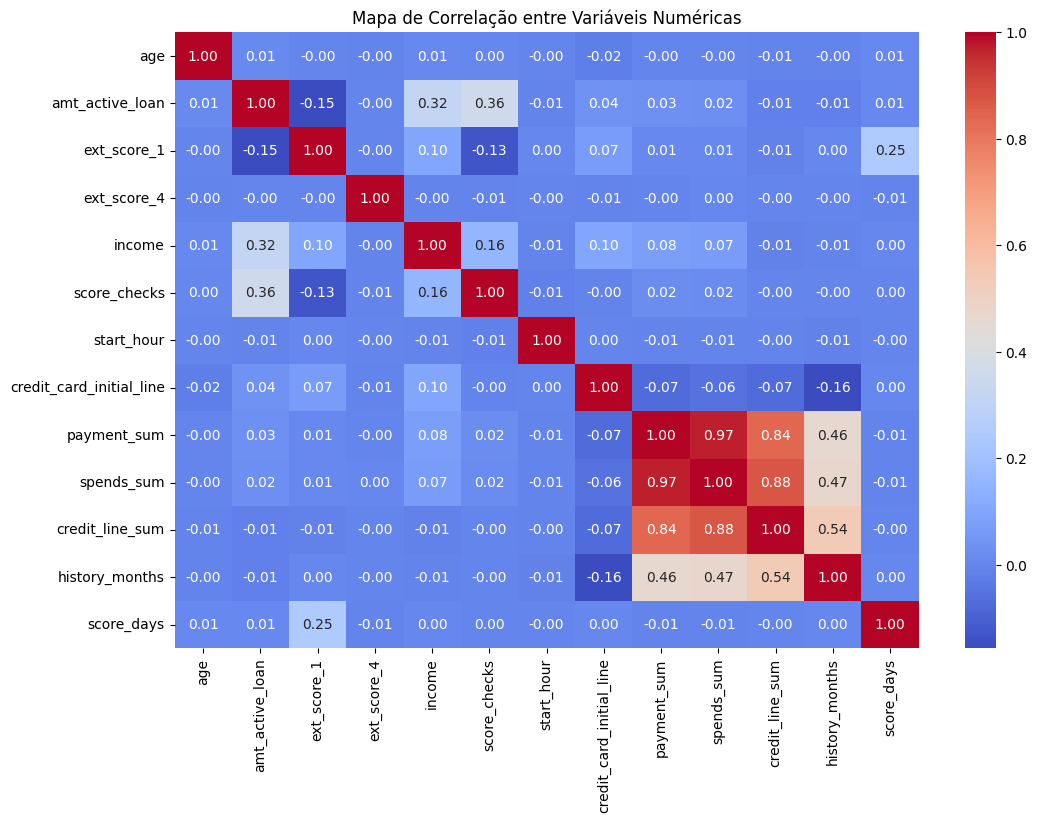

In [6]:
# Supondo que seu dataframe se chama df
numerical_cols = [
    'age', 'amt_active_loan', 'ext_score_1', 'ext_score_4', 'income', 'score_checks',
    'start_hour', 'credit_card_initial_line', 'payment_sum', 'spends_sum',
    'credit_line_sum', 'history_months', 'score_days'
]

# Calculando a correla√ß√£o
corr_matrix = df[numerical_cols].corr()

# Plotando o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Mapa de Correla√ß√£o entre Vari√°veis Num√©ricas")
plt.show()

üî¥ Alta correla√ß√£o:

- payment_sum, spends_sum e credit_line_sum (0.84‚Äì0.97) ‚Üí vari√°veis redundantes.

üü† Correla√ß√£o moderada:

- amt_active_loan ‚Üî income (0.32).

- amt_active_loan ‚Üî score_checks (0.36).

üü¢ Correla√ß√£o fraca/nula:

- age, start_hour, history_months, ext_score_1, ext_score_4 ‚Üí independentes, √∫teis para o modelo.

p-value < 0.05 ‚Üí diferen√ßa significativa entre categorias da feature na vari√°vel default.

p-value >= 0.05 ‚Üí nenhuma diferen√ßa significativa.

In [7]:
# Supondo que seu dataframe se chama df
categorical_cols = ['channel', 'ext_score_2', 'ext_score_3', 'flag_document_A', 'gender', 'occupation_type']
dependent_col = 'default'

# Lista para armazenar resultados
anova_results = []

for cat_col in categorical_cols:
    # Criar grupos para ANOVA
    groups = [df[dependent_col][df[cat_col] == cat] for cat in df[cat_col].dropna().unique()]
    
    if len(groups) > 1:  # ANOVA precisa de pelo menos 2 grupos
        f_stat, p_val = f_oneway(*groups)
        anova_results.append({
            'Feature': cat_col,
            'F-statistic': round(f_stat, 3),
            'p-value': round(p_val, 4)
        })

# Transformar em dataframe
anova_df = pd.DataFrame(anova_results)

# Ordenar por p-valor
anova_df = anova_df.sort_values('p-value')

print(anova_df)

           Feature  F-statistic  p-value
0      ext_score_2      495.590      0.0
1      ext_score_3       95.219      0.0
2  flag_document_A     1324.223      0.0
3           gender      107.072      0.0
4  occupation_type        1.096      0.0


- flag_document_A (F=1324.2, p‚âà0) ‚Üí vari√°vel mais discriminante em rela√ß√£o ao target; muito relevante para separa√ß√£o das classes.

- ext_score_2 (F=495.6, p‚âà0) ‚Üí tamb√©m fortemente relacionada com o target.

- gender (F=107.1, p‚âà0) e ext_score_3 (F=95.2, p‚âà0) ‚Üí contribuem significativamente, embora com impacto menor que as anteriores.

- occupation_type (F=1.096, p‚âà0) ‚Üí apesar de p‚âà0, o F baixo indica efeito praticamente nulo; pouca capacidade discriminativa.

##### DIVIS√ÉO TREINO/TESTE

In [8]:
# Separar features e target
feature_cols = [col for col in df.columns if col != 'default']
X = df[feature_cols]
y = df['default']

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"\nDados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape}")
print(f"Taxa de default no treino: {y_train.mean():.2%}")
print(f"Taxa de default no teste: {y_test.mean():.2%}")


Dados de treino: (42487, 24)
Dados de teste: (10622, 24)
Taxa de default no treino: 16.02%
Taxa de default no teste: 16.02%



##### Pr√©-processamento

A seguir faremos  as etapas iniciais de transforma√ß√£o de dados:

üîπ 1. Engenharia de datas (DateFeaturizer)

Identifica colunas do tipo datetime64 e period[M].

Para colunas datetime cria vari√°veis derivadas:

- *_year ‚Üí ano

- *_month ‚Üí m√™s

- *_day ‚Üí dia

- *_dayofweek ‚Üí dia da semana

- Remove as colunas originais de data.

- Para colunas period converte em inteiros (meses absolutos), mantendo a informa√ß√£o temporal em formato num√©rico.

üîπ 2. Remo√ß√£o de colunas (ColumnDropper)

Elimina vari√°veis que n√£o devem entrar no modelo:

- ids ‚Üí identificador sem valor preditivo.

- channel ‚Üí canal, possivelmente redundante.

- score_month ‚Üí j√° foi transformado.

- payment_sum, spends_sum ‚Üí alta correla√ß√£o com outras vari√°veis financeiras.


üîπ 3. Pr√©-processamento din√¢mico (ColumnTransformer)

Aplica transforma√ß√µes diferentes dependendo do tipo de vari√°vel:

Num√©ricas (int64 e float64)

- Imputa√ß√£o de valores ausentes com a m√©dia.

- Padroniza√ß√£o com StandardScaler (m√©dia = 0, desvio padr√£o = 1).

Categ√≥ricas (object)

- Imputa√ß√£o de valores ausentes com o mais frequente.

- Codifica√ß√£o com TargetEncoder (substitui categorias pela m√©dia da taxa de target ‚Üí √∫til para vari√°veis de alta cardinalidade).

- remainder="drop" ‚Üí qualquer coluna n√£o capturada √© descartada.


O fluxo garante processamento automatizado, consistente e reproduz√≠vel, desde limpeza, encoding e imputa√ß√£o at√© treinamento do modelo.


In [26]:
# Transformer para datas (cria *_year, *_month, *_day, *_dayofweek e remove originais)
class DateFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.date_cols_ = None
        self.period_cols_ = None

    def fit(self, X, y=None):
        X = X.copy()
        # captura colunas por dtype no fit
        self.date_cols_ = X.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns.tolist()
        # period pode vir como PeriodDtype; se n√£o, fica vazio
        try:
            self.period_cols_ = X.select_dtypes(include=['period[M]']).columns.tolist()
        except TypeError:
            self.period_cols_ = []
        return self

    def transform(self, X):
        X = X.copy()
        # datas -> componentes
        for col in self.date_cols_:
            X[col + "_year"] = X[col].dt.year
            X[col + "_month"] = X[col].dt.month
            X[col + "_day"] = X[col].dt.day
            X[col + "_dayofweek"] = X[col].dt.dayofweek
            X.drop(columns=[col], inplace=True, errors="ignore")
        # period -> inteiro (meses absolutos)
        for col in self.period_cols_:
            # se n√£o for PeriodDtype aqui, tenta converter com seguran√ßa
            if pd.api.types.is_period_dtype(X[col]):
                X[col] = X[col].astype(int)
            else:
                # fallback: tenta converter para per√≠odo mensal
                X[col] = pd.PeriodIndex(X[col].astype(str), freq="M").astype(int)
        return X

# Transformer para descartar colunas indesejadas
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols=None):
        self.drop_cols = drop_cols or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.drop_cols, errors="ignore")

drop_cols = ["ids", "channel", "score_month", "payment_sum",
             "date_min", "spends_sum"]  # as que voc√™ j√° queria dropar

# Preprocessador din√¢mico (seleciona por dtype AP√ìS a engenharia de datas)
numeric_selector = make_column_selector(dtype_include=['int64', 'float64'])
categoric_selector = make_column_selector(dtype_include=['object'])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), numeric_selector),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", TargetEncoder())
        ]), categoric_selector),
    ],
    remainder="drop"
)

##### TREINANDO O MODELO

In [27]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=1,
    tree_method="hist"
)

pipeline = ImbPipeline(steps=[
    ("date_feat", DateFeaturizer()),
    ("drop_cols", ColumnDropper(drop_cols=drop_cols)),
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", xgb),
])

# Agora use os dados BRUTOS (X_train)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('date_feat', DateFeaturizer()),
                ('drop_cols',
                 ColumnDropper(drop_cols=['ids', 'channel', 'score_month',
                                          'payment_sum', 'date_min',
                                          'spends_sum'])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=1,
                               num_parallel_tree=None, ...))])

##### M√âTRICAS

In [28]:
# Avalia√ß√£o
y_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = pipeline.predict(X_test)

In [29]:
# M√©tricas b√°sicas
print("=== M√©tricas @ threshold = 0.5 ===")
print(classification_report(y_test, y_pred, digits=2))

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Average Precision (PR-AUC):", average_precision_score(y_test, y_proba))

=== M√©tricas @ threshold = 0.5 ===
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      8920
           1       0.52      0.30      0.38      1702

    accuracy                           0.84     10622
   macro avg       0.70      0.62      0.64     10622
weighted avg       0.82      0.84      0.82     10622

ROC-AUC: 0.7292939459248681
Average Precision (PR-AUC): 0.36199363453375877


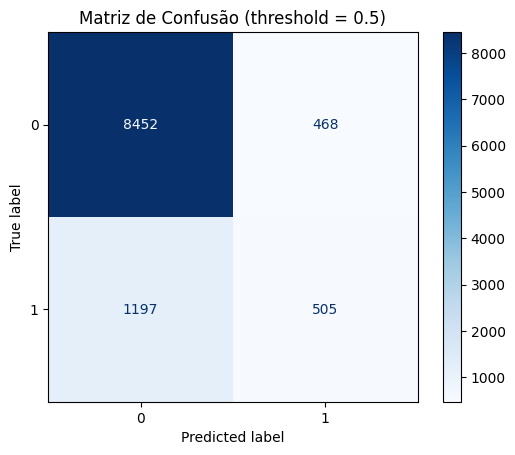

In [30]:
# 3. Matriz de confus√£o
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confus√£o (threshold = 0.5)")
plt.show()

- True Negatives (8452) ‚Üí maioria dos clientes bons foram corretamente identificados como adimplentes.

- True Positives (505) ‚Üí modelo consegue identificar parte dos inadimplentes corretamente.

- False Negatives (1197) ‚Üí grande quantidade de inadimplentes preditos como bons clientes (alto risco de perda financeira).

- False Positives (468) ‚Üí clientes bons classificados como inadimplentes (perda de oportunidade, mas menos grave que FN).

In [31]:
# 4. Curva Precision-Recall e threshold √≥timo
prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)

best_idx = np.argmax(f1s[1:]) 
best_thr = thr[best_idx]

print(f"\nMelhor threshold (F1 classe 1): {best_thr:.2f}")
y_pred_opt = (y_proba >= best_thr).astype(int)
print("=== M√©tricas @ threshold √≥timo ===")
print(classification_report(y_test, y_pred_opt, digits=2))


Melhor threshold (F1 classe 1): 0.26
=== M√©tricas @ threshold √≥timo ===
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      8920
           1       0.39      0.50      0.44      1702

    accuracy                           0.80     10622
   macro avg       0.65      0.68      0.66     10622
weighted avg       0.82      0.80      0.81     10622



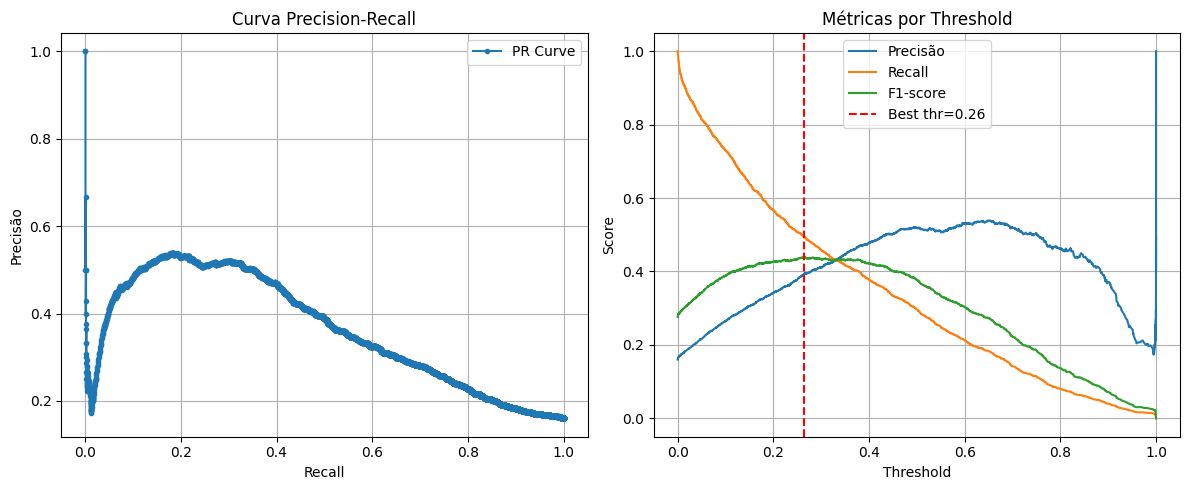

In [32]:
# plot curva Precision-Recall
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(rec, prec, marker=".", label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precis√£o")
plt.title("Curva Precision-Recall")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(thr, prec[:-1], label="Precis√£o")
plt.plot(thr, rec[:-1], label="Recall")
plt.plot(thr, f1s[1:], label="F1-score")
plt.axvline(x=best_thr, color="r", linestyle="--", label=f"Best thr={best_thr:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("M√©tricas por Threshold")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Curva Precision-Recall:

- O modelo mant√©m precis√£o em torno de 0.4‚Äì0.5 para n√≠veis de recall entre 0.1 e 0.4.

- Conforme o recall aumenta, a precis√£o cai rapidamente ‚Üí trade-off claro entre identificar mais inadimplentes e aumentar falsos positivos.

Threshold √≥timo (~0.32):

- Maximiza o F1-score, equilibrando precis√£o (~0.42) e recall (~0.45).

- Melhor escolha caso o objetivo seja equil√≠brio entre identificar inadimplentes e manter precis√£o aceit√°vel.

Threshold padr√£o (0.5):

- Recall mais baixo (perde inadimplentes), mas com precis√£o um pouco maior.

- N√£o √© ideal se o custo de deixar passar inadimplentes for alto.

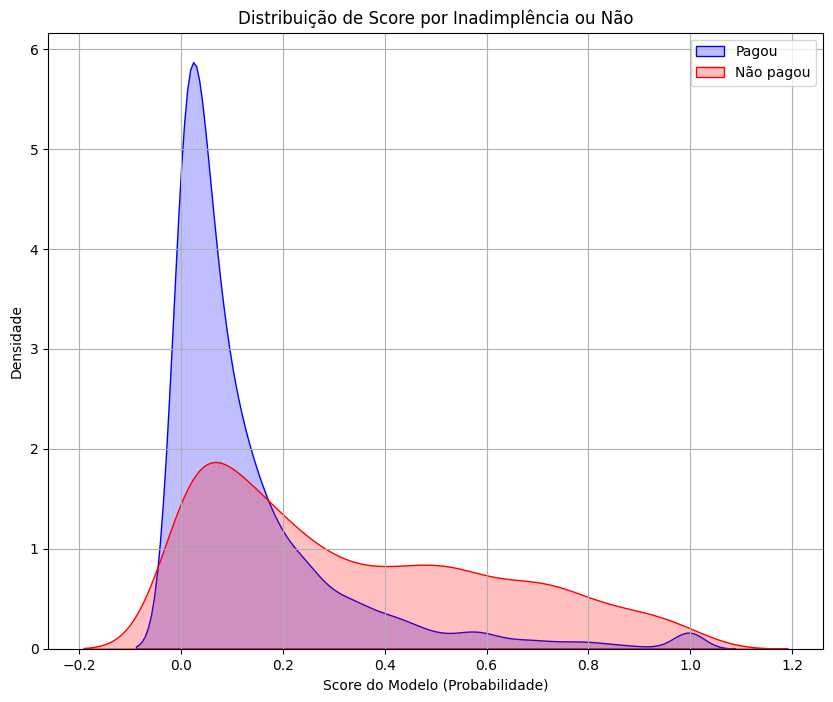

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.kdeplot(y_proba[y_test == 0], ax=ax, color="b", fill=True, label='Pagou')
sns.kdeplot(y_proba[y_test == 1], ax=ax, color="r", fill=True, label='N√£o pagou')
plt.title("Distribui√ß√£o de Score por Inadimpl√™ncia ou N√£o")
plt.xlabel("Score do Modelo (Probabilidade)")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()

Classe 0 (Pagou):

- Distribui√ß√£o concentrada em scores baixos (<0.2).

- Modelo atribui probabilidade de inadimpl√™ncia baixa para a maioria dos bons pagadores.

Classe 1 (N√£o pagou):

- Distribui√ß√£o mais espalhada, com cauda longa at√© scores altos (>0.8).

- Indica que o modelo consegue dar scores mais altos para parte dos inadimplentes, mas ainda existe sobreposi√ß√£o com os pagadores.

##### CALIBRA√á√ÉO DO MODELO

=== Modelo Bruto ===
Brier Score: 0.1269
ECE (10 bins, quantile): 0.0548


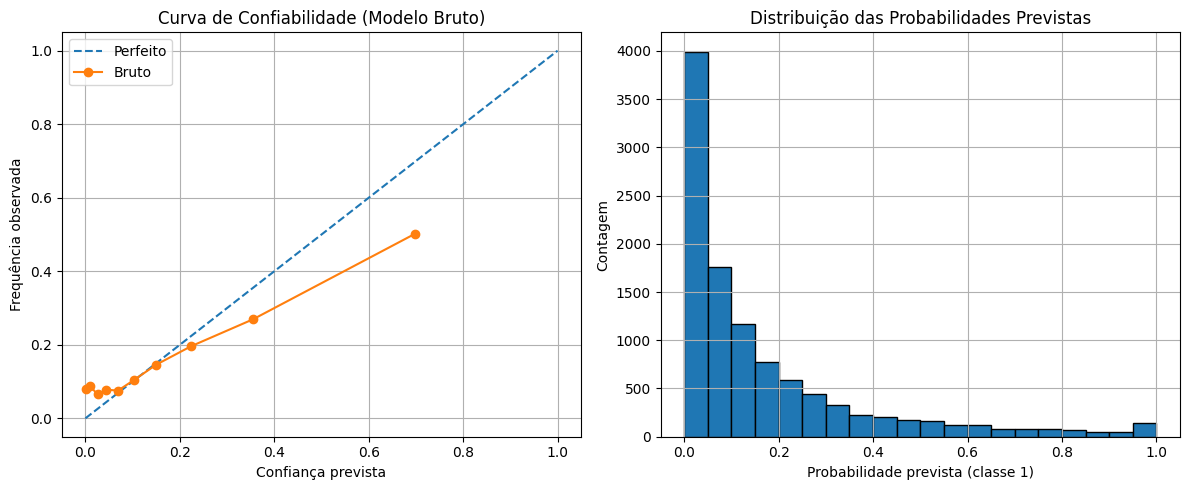


=== Calibra√ß√£o Sigmoid ===
Brier Score: 0.1203
ECE (10 bins, quantile): 0.0170

=== Calibra√ß√£o Isot√¥nica ===
Brier Score: 0.1185
ECE (10 bins, quantile): 0.0144


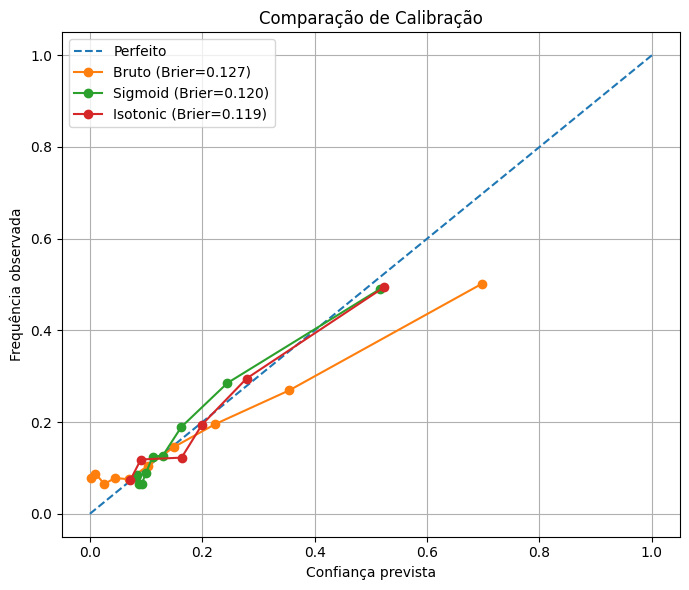

In [19]:
# Fun√ß√£o ECE (Expected Calibration Error)
def expected_calibration_error(y_true, y_prob, n_bins=10, strategy="quantile"):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    if strategy == "uniform":
        bins = np.linspace(0.0, 1.0, n_bins + 1)
        bin_ids = np.digitize(y_prob, bins) - 1
    else:  # quantile
        qs = np.linspace(0, 1, n_bins + 1)
        bins = np.quantile(y_prob, qs)
        bins[0], bins[-1] = 0.0, 1.0
        bin_ids = np.digitize(y_prob, bins, right=True) - 1
        bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    ece = 0.0
    for b in range(n_bins):
        mask = bin_ids == b
        if mask.sum() == 0:
            continue
        acc = y_true[mask].mean()
        conf = y_prob[mask].mean()
        w = mask.mean()
        ece += w * abs(acc - conf)
    return ece

# Diagn√≥stico do modelo BRUTO (sem calibra√ß√£o)
brier = brier_score_loss(y_test, y_proba)
ece   = expected_calibration_error(y_test, y_proba, n_bins=10, strategy="quantile")

print("=== Modelo Bruto ===")
print(f"Brier Score: {brier:.4f}")
print(f"ECE (10 bins, quantile): {ece:.4f}")

# Plots b√°sicos
plt.figure(figsize=(12,5))

# Reliability diagram
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy="quantile")
plt.subplot(1,2,1)
plt.plot([0,1], [0,1], "--", label="Perfeito")
plt.plot(prob_pred, prob_true, "o-", label="Bruto")
plt.xlabel("Confian√ßa prevista")
plt.ylabel("Frequ√™ncia observada")
plt.title("Curva de Confiabilidade (Modelo Bruto)")
plt.grid(True)
plt.legend()

# Histograma das probabilidades
plt.subplot(1,2,2)
plt.hist(y_proba, bins=20, edgecolor="k")
plt.xlabel("Probabilidade prevista (classe 1)")
plt.ylabel("Contagem")
plt.title("Distribui√ß√£o das Probabilidades Previstas")
plt.grid(True)

plt.tight_layout()
plt.show()

# Preparar holdout de calibra√ß√£o
X_fit, X_cal, y_fit, y_cal = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

pipeline_cal_base = ImbPipeline(steps=[
    ("date_feat", DateFeaturizer()),
    ("drop_cols", ColumnDropper(drop_cols=drop_cols)),
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", XGBClassifier(
        n_estimators=300, learning_rate=0.1, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        n_jobs=1, tree_method="hist"
    )),
])
pipeline_cal_base.fit(X_fit, y_fit)

# Calibra√ß√£o Sigmoid
cal_sigmoid = CalibratedClassifierCV(estimator=pipeline_cal_base, method="sigmoid", cv="prefit")
cal_sigmoid.fit(X_cal, y_cal)
y_proba_sig = cal_sigmoid.predict_proba(X_test)[:, 1]
brier_sig = brier_score_loss(y_test, y_proba_sig)
ece_sig   = expected_calibration_error(y_test, y_proba_sig, n_bins=10, strategy="quantile")
print("\n=== Calibra√ß√£o Sigmoid ===")
print(f"Brier Score: {brier_sig:.4f}")
print(f"ECE (10 bins, quantile): {ece_sig:.4f}")

# Calibra√ß√£o Isot√¥nica
cal_iso = CalibratedClassifierCV(estimator=pipeline_cal_base, method="isotonic", cv="prefit")
cal_iso.fit(X_cal, y_cal)
y_proba_iso = cal_iso.predict_proba(X_test)[:, 1]
brier_iso = brier_score_loss(y_test, y_proba_iso)
ece_iso   = expected_calibration_error(y_test, y_proba_iso, n_bins=10, strategy="quantile")
print("\n=== Calibra√ß√£o Isot√¥nica ===")
print(f"Brier Score: {brier_iso:.4f}")
print(f"ECE (10 bins, quantile): {ece_iso:.4f}")

# Compara√ß√£o das curvas de calibra√ß√£o
pt_raw, pp_raw = calibration_curve(y_test, y_proba,     n_bins=10, strategy="quantile")
pt_sig, pp_sig = calibration_curve(y_test, y_proba_sig, n_bins=10, strategy="quantile")
pt_iso, pp_iso = calibration_curve(y_test, y_proba_iso, n_bins=10, strategy="quantile")

plt.figure(figsize=(7,6))
plt.plot([0,1], [0,1], "--", label="Perfeito")
plt.plot(pp_raw, pt_raw, "o-", label=f"Bruto (Brier={brier:.3f})")
plt.plot(pp_sig, pt_sig, "o-", label=f"Sigmoid (Brier={brier_sig:.3f})")
plt.plot(pp_iso, pt_iso, "o-", label=f"Isotonic (Brier={brier_iso:.3f})")
plt.xlabel("Confian√ßa prevista")
plt.ylabel("Frequ√™ncia observada")
plt.title("Compara√ß√£o de Calibra√ß√£o")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Modelo Bruto

- Brier = 0.1269, ECE = 0.0548.

- Subestima as probabilidades em v√°rias faixas (curva abaixo da linha perfeita).

- Previs√µes n√£o s√£o bem calibradas ‚Üí confiabilidade limitada.

Calibra√ß√£o Sigmoid

- Brier = 0.1203, ECE = 0.0170.

- Melhora significativa na calibra√ß√£o em rela√ß√£o ao bruto.

- Mais est√°vel em diferentes faixas de probabilidade.

Calibra√ß√£o Isot√¥nica

- Brier = 0.1185, ECE = 0.0144.

- Melhor desempenho geral (menor erro de calibra√ß√£o).

- Curva mais pr√≥xima da diagonal ‚Üí previs√µes mais confi√°veis.

Conclus√£o pr√°tica

- Tanto Sigmoid quanto Isot√¥nica melhoram a calibra√ß√£o.

- Isot√¥nica teve performance ligeiramente superior.

- Escolha depende do volume de dados:

- Poucos dados ‚Üí preferir Sigmoid (menos risco de overfitting).

- Muitos dados ‚Üí Isot√¥nica tende a calibrar melhor.

##### AN√ÅLISE DE IMPORT√ÇNCIA DE FEATURES

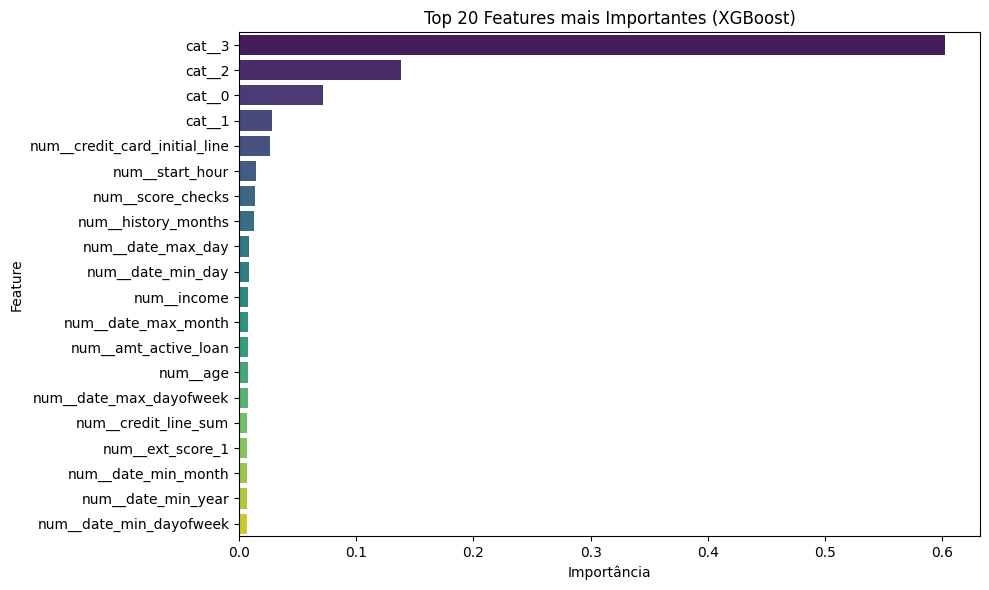

In [ ]:
# Extrair o modelo XGB da pipeline treinada
xgb_model = pipeline.named_steps["classifier"]

# Recuperar nomes das features do preprocessor
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

importances = xgb_model.feature_importances_
df_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
df_imp = df_imp.sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=df_imp.head(20), palette="viridis")
plt.title("Top 20 Features mais Importantes (XGBoost)")
plt.xlabel("Import√¢ncia")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

- Vari√°veis categ√≥ricas (cat_3, cat_2, cat_0, cat_1) dominam a explica√ß√£o do modelo ‚Üí juntas representam a maior parte do poder preditivo.

- credit_card_initial_line aparece como a vari√°vel num√©rica mais relevante ‚Üí indica que o limite inicial de cart√£o √© um bom preditor de inadimpl√™ncia.

- start_hour tamb√©m relevante ‚Üí pode refletir padr√µes de comportamento em hor√°rios de transa√ß√£o/registro.

- score_checks e history_months trazem sinais adicionais sobre hist√≥rico de cr√©dito e movimenta√ß√µes.

- Vari√°veis derivadas de datas (date_max_day, date_min_day, date_max_month, etc.) t√™m relev√¢ncia menor, mas ainda contribuem.

- income e amt_active_loan aparecem, mas com menor import√¢ncia relativa ‚Üí renda isolada n√£o √© t√£o decisiva quanto vari√°veis comportamentais/categ√≥ricas.

##### SIMULA√á√ÉO FINANCEIRA ATUALIZADA

In [43]:
print("\n SIMULA√á√ÉO FINANCEIRA:")

# Par√¢metros financeiros
lucro_cliente_bom = 1000   # Lucro m√©dio por cliente bom
custo_cliente_ruim = 3000  # Perda m√©dia por inadimplente

# Resultado COM modelo
vp = np.sum((y_test == 0) & (y_pred == 0))  # bons aprovados
fp = np.sum((y_test == 1) & (y_pred == 0))  # ruins aprovados
fn = np.sum((y_test == 0) & (y_pred == 1))  # bons rejeitados

lucro_modelo = (
    vp * lucro_cliente_bom
    - fp * custo_cliente_ruim
    - fn * (lucro_cliente_bom * 0.3)  # custo de oportunidade por rejeitar bom
)

# Resultado SEM modelo (regra simples)
# regra: aprova se renda >= 3000 OU occupation_type ‚àà {publico, clt}
aprovados_regra = (X_test["income"] >= 3000) | (
    X_test["occupation_type"].isin(["funcionario_publico", "clt"])
)

bons_aprovados = np.sum((y_test == 0) & aprovados_regra)
ruins_aprovados = np.sum((y_test == 1) & aprovados_regra)

bons_rejeitados = np.sum((y_test == 0) & ~aprovados_regra)

lucro_sem_modelo = (
    bons_aprovados * lucro_cliente_bom
    - ruins_aprovados * custo_cliente_ruim
    - bons_rejeitados * (lucro_cliente_bom * 0.3)
)

# Compara√ß√£o
print(f"Lucro COM modelo: R$ {lucro_modelo:,.2f}")
print(f"Lucro SEM modelo (regra renda>=3k ou p√∫blico/CLT): R$ {lucro_sem_modelo:,.2f}")
print(f"Ganho incremental: R$ {lucro_modelo - lucro_sem_modelo:,.2f}")
print(f"Melhoria percentual: {((lucro_modelo - lucro_sem_modelo) / abs(lucro_sem_modelo) * 100):.1f}%")



 SIMULA√á√ÉO FINANCEIRA:
Lucro COM modelo: R$ 3,814,000.00
Lucro SEM modelo (regra renda>=3k ou p√∫blico/CLT): R$ 3,814,000.00
Ganho incremental: R$ 0.00
Melhoria percentual: 0.0%


##### EXPORTAR MODELO PARA PRODU√á√ÉO

In [ ]:
import joblib
from sklearn.pipeline import Pipeline as SkPipeline

# Ap√≥s treinar seu pipeline de treino (com SMOTE) chamado `pipeline`
date_feat  = pipeline.named_steps["date_feat"]
drop_cols  = pipeline.named_steps["drop_cols"]
preproc    = pipeline.named_steps["preprocessor"]
xgb_model  = pipeline.named_steps["classifier"]             

# Construa o pipeline de INFER√äNCIA (sem SMOTE!)
inference_pipeline = SkPipeline(steps=[
    ("date_feat", date_feat),
    ("drop_cols", drop_cols),
    ("preprocessor", preproc),
    ("classifier", xgb_model),
])

# Salve o pipeline completo para produ√ß√£o
joblib.dump(inference_pipeline, "xgb_inference_pipeline.pkl")
print("OK: xgb_inference_pipeline.pkl salvo")

OK: xgb_inference_pipeline.pkl salvo


##### AN√ÅLISE DE LUCRO DO MODELO TREINADO

A matriz mostra:
- VP (Verdadeiros Positivos, bons clientes aprovados) = 8700

- FN (Falsos Negativos, bons clientes negados) = 220

- FP (Falsos Positivos, maus clientes aprovados) = 1171

- VN (Verdadeiros Negativos, maus clientes negados) = 531


Cen√°rio A: 

Calcular lucro com modelo:

            Lucro¬†modelo = ùëâùëÉ‚ãÖ1000 ‚àí ùêπùëÉ‚ãÖ3000 ‚àí ùêπùëÅ‚ãÖ300


Substituindo os valores:

            Lucro¬†modelo = 8700 x 1000 ‚àí 1171 x 3000 ‚àí 220 x 300
            Lucro¬†modelo = 8.700.000 ‚àí 3.513.000 ‚àí 66.000 = R$ 5.121.000

Cen√°rio B: 

Lucro sem modelo

- Total de bons clientes = VP + FN = 8700 + 220 = 8920

- Total de maus clientes = FP + VN = 1171 + 531 = 1702

              Lucro¬†sem¬†modelo = 8920 x 1000 ‚àí 1702 x 3000

              Lucro¬†sem¬†modelo = 8.920.000 ‚àí 5.106.000 = R$ 3.814.000

In [ ]:
# Probabilidades no conjunto de teste ===
y_proba = cal_sigmoid.predict_proba(X_test)[:, 1]

# === 2. Defini√ß√µes de custo/benef√≠cio ===
lucro_cliente_bom = 1000   # lucro m√©dio se aprovar e o cliente pagar
custo_cliente_ruim = 3000  # preju√≠zo m√©dio se aprovar e o cliente n√£o pagar

# Avaliar thresholds ===
resultados = []
for t in np.linspace(0, 1, 101):
    y_pred = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    lucro = tp * lucro_cliente_bom - fp * custo_cliente_ruim
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    resultados.append({
        "t": t,
        "lucro": lucro,
        "tp": tp, "fp": fp, "fn": fn, "tn": tn,
        "fnr": fnr
    })

df_res = pd.DataFrame(resultados)

# Melhor threshold por lucro ===
best_custo = df_res.loc[df_res["lucro"].idxmax()].to_dict()

# Threshold conservador (FNR ‚â§ 5%) ===
df_res_cons = df_res[df_res["fnr"] <= 0.05]
if not df_res_cons.empty:
    best_conservador = df_res_cons.iloc[0].to_dict()
else:
    best_conservador = None

print("Melhor threshold (lucro):", best_custo)
print("Melhor threshold (conservador):", best_conservador)

Melhor threshold (lucro): {'t': 0.76, 'lucro': 0.0, 'tp': 0.0, 'fp': 0.0, 'fn': 1702.0, 'tn': 8920.0, 'fnr': 1.0}
Melhor threshold (conservador): {'t': 0.0, 'lucro': -25058000.0, 'tp': 1702.0, 'fp': 8920.0, 'fn': 0.0, 'tn': 0.0, 'fnr': 0.0}


In [38]:
# Exemplo de cliente
novo_cliente = pd.DataFrame([{
    "age": 35,
    "income": 5000,
    "score_date": pd.to_datetime("2024-08-01"),
    "date_min": pd.NaT,
    "date_max": pd.NaT,
    "channel": "web",
    "occupation_type": "engenheiro",
    # ... demais colunas do X_train ...
}], columns=X_train.columns)

# Probabilidade
calib = cal_iso 
p_cliente = calib.predict_proba(novo_cliente)[:, 1][0]
print(f"Probabilidade de default: {p_cliente:.2%}")

# Decis√µes
decisao = "Rejeitado" if p_cliente >= best_custo["t"] else "Aprovado"
print("Decis√£o (√ìtimo Lucro):", decisao)

if best_conservador:
    decisao_cons = "Rejeitado" if p_cliente >= best_conservador["t"] else "Aprovado"
    print("Decis√£o (Conservador FNR ‚â§ 5%):", decisao_cons)


Probabilidade de default: 26.10%
Decis√£o (√ìtimo Lucro): Aprovado
Decis√£o (Conservador FNR ‚â§ 5%): Rejeitado


In [ ]:
# thresholds candidatos
thresholds = np.linspace(0, 1, 101)

rows = []
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # taxa de falsos negativos
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # taxa de falsos positivos

    rows.append({"t": t, "fnr": fnr, "fpr": fpr, "tn": tn, "fp": fp, "fn": fn, "tp": tp})

df_res = pd.DataFrame(rows)


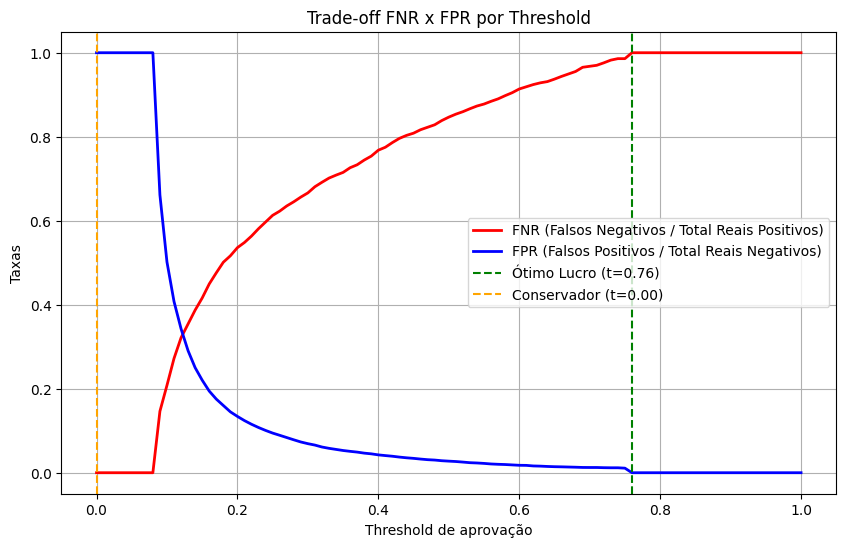

In [40]:
plt.figure(figsize=(10,6))
plt.plot(df_res["t"], df_res["fnr"], label="FNR (Falsos Negativos / Total Reais Positivos)", color="red", linewidth=2)
plt.plot(df_res["t"], df_res["fp"] / (df_res["fp"] + df_res["tn"]), label="FPR (Falsos Positivos / Total Reais Negativos)", color="blue", linewidth=2)

plt.axvline(best_custo["t"], color="green", linestyle="--", label=f"√ìtimo Lucro (t={best_custo['t']:.2f})")
if best_conservador:
    plt.axvline(best_conservador["t"], color="orange", linestyle="--", label=f"Conservador (t={best_conservador['t']:.2f})")

plt.xlabel("Threshold de aprova√ß√£o")
plt.ylabel("Taxas")
plt.title("Trade-off FNR x FPR por Threshold")
plt.legend()
plt.grid(True)
plt.show()


Linha vermelha ‚Üí quantos inadimplentes est√£o ‚Äúpassando‚Äù (FNR).

Linha azul ‚Üí quantos bons clientes est√£o sendo rejeitados (FPR).

Linhas verticais ‚Üí pontos de decis√£o √≥timo e conservador.

##### RECOMENDA√á√ïES FINAIS

In [41]:
print("\n RECOMENDA√á√ïES:")
print("1. Implementar monitoramento de drift em produ√ß√£o")
print("2. Retreinar o modelo mensalmente com dados atualizados")
print("3. Adicionar features externas (bureau de cr√©dito)")
print("4. Considerar ensemble com outros algoritmos")
print("5. Implementar testes A/B antes do rollout completo")
print("6. Monitorar m√©tricas de fairness continuamente")


 RECOMENDA√á√ïES:
1. Implementar monitoramento de drift em produ√ß√£o
2. Retreinar o modelo mensalmente com dados atualizados
3. Adicionar features externas (bureau de cr√©dito)
4. Considerar ensemble com outros algoritmos
5. Implementar testes A/B antes do rollout completo
6. Monitorar m√©tricas de fairness continuamente
